In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
from utils import *

In [216]:
import glob
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np

In [69]:
paths = sorted(glob.glob(os.path.join(RAW_DATA_PATH, '*.csv')))

In [71]:
paths[:10]

['midas-applied-ds/Data/Raw/VED/VED_171101_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171108_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171115_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171122_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171129_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171206_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171213_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171220_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_171227_week.csv',
 'midas-applied-ds/Data/Raw/VED/VED_180103_week.csv']

In [72]:
os.path.basename(paths[10])
os.path.basename(paths[0])

'VED_171101_week.csv'

In [119]:
nonEVpath = 'VED_Static_Data_ICE&HEV.csv'
nonEVs = pd.read_csv(nonEVpath)
nonEVs
nonEV_IDs = pd.Series(nonEVs.VehId)
nonEV_IDs

0        2
1        5
2        7
3        8
4       12
      ... 
351    616
352    618
353    624
354    625
355    630
Name: VehId, Length: 356, dtype: int64

In [85]:
nonEVs.loc[nonEVs['VehId'] == 2, 'Vehicle Type'][0]

'ICE'

In [82]:
data = pd.read_csv(paths[0])
print(paths[0])

midas-applied-ds/Data/Raw/VED/VED_171101_week.csv


In [42]:
data['Trip'][0]

706

In [41]:
data['Trip'].value_counts()

1866    6358
736     3391
789     3116
990     3016
982     2958
        ... 
893      106
60       106
325      105
1599     103
768      101
Name: Trip, Length: 658, dtype: int64

In [37]:
data.columns

Index(['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Latitude[deg]',
       'Longitude[deg]', 'Vehicle Speed[km/h]', 'MAF[g/sec]',
       'Engine RPM[RPM]', 'Absolute Load[%]', 'OAT[DegC]', 'Fuel Rate[L/hr]',
       'Air Conditioning Power[kW]', 'Air Conditioning Power[Watts]',
       'Heater Power[Watts]', 'HV Battery Current[A]', 'HV Battery SOC[%]',
       'HV Battery Voltage[V]', 'Short Term Fuel Trim Bank 1[%]',
       'Short Term Fuel Trim Bank 2[%]', 'Long Term Fuel Trim Bank 1[%]',
       'Long Term Fuel Trim Bank 2[%]'],
      dtype='object')

In [38]:
ave_speed_func = lambda x: x['Vehicle Speed[km/h]'].mean()
ave_speed = extract_trip_info(paths[:2], ave_speed_func)

100%|██████████| 2/2 [01:09<00:00, 34.79s/it]


In [39]:
ave_speed

,Trip,values
0,1866,5.864737
1,736,25.347095
2,789,55.677340
3,990,38.500205
4,982,37.081812
...,...,...
1038,1110,69.907407
1039,1057,39.809524
1040,310,45.211538
1041,1301,44.634615


(array([  8.,  74., 235., 356., 223.,  84.,  33.,  14.,  12.,   2.]),
 array([  2.61940299,  12.81421556,  23.00902814,  33.20384071,
         43.39865329,  53.59346586,  63.78827844,  73.98309101,
         84.17790359,  94.37271616, 104.56752874]),
 <BarContainer object of 10 artists>)

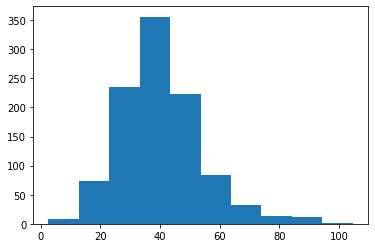

In [32]:
plt.hist(ave_speed['values'])

In [54]:
all_data = extract_trip_info(RAW_PATHS, ave_speed_func, name='averageSpeed')

100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


In [39]:
all_data.shape

(4153, 2)

In [47]:
max_speed_func = lambda x:x['Vehicle Speed[km/h]'].max()
max_speed = extract_trip_info(RAW_PATHS, max_speed_func, name = 'maxSpeed')

100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


In [55]:
all_data = pd.merge(all_data, max_speed, on='Trip')

In [56]:
all_data

,Trip,averageSpeed,maxSpeed
0,1866,54.706383,68.0
1,736,44.024490,69.0
2,789,41.033951,75.0
3,990,51.011009,75.0
4,982,62.472637,91.0
...,...,...,...
4148,3054,45.772321,73.0
4149,3473,49.724551,81.0
4150,11580,39.347682,63.0
4151,8788,50.596364,82.0


In [73]:
'''
Instantaneous Fuel Consumption Algorithm (MAF, Absolute Load, Displacement_eng, RPM_eng):
    if Fuel Rate is available then
        return Fuel Rate
    else if MAF is available then
        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)
        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)
        return Inst Fuel Consumption Rate
    else if Absolute Load and RPM_eng are available then
        MAF = 1.84 * displacement * absLoad/100 * RPM/2/60
        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)
        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)
        return Inst Fuel Consumption Rate
    else
        return NaN
'''


'\nInstantaneous Fuel Consumption Algorithm (MAF, Absolute Load, Displacement_eng, RPM_eng, p_air, Fuel Rate, AFR, FD):\n    if Fuel Rate is available then\n        return Fuel Rate\n    else if MAF is available then\n        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)\n        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)\n        return Inst Fuel Consumption Rate\n    else if Absolute Load and RPM_eng are available then\n        MAF = Absolute Load/100 * p_air * Displacement_eng * RPM_eng * 120\n        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)\n        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)\n        return Inst Fuel Consumption Rate\n    else\n        return NaN\n'

In [262]:
def inst_fuel_algo(MAF, absLoad, RPM, vehicle_speed, VehID, nonEV_IDs):

    if MAF is not 'NaN':
        fuel_flow = (MAF * 3600)/(14.7 * 820)
        if vehicle_speed is 0:
            return 0
        inst_rate = fuel_flow / vehicle_speed
        if inst_rate is 'inf':
            return 0
        return inst_rate
    elif absLoad is not 'NaN':
        displacement = nonEVs.loc[nonEVs['VehId'] == VehID, 'Engine Configuration & Displacement'][0]
        displacement = float(displacement.split(" ")[1].strip("L"))
        MAF = 1.84 * displacement * absLoad/100 * RPM/2/60
        fuel_flow = (MAF * 3600)*(14.7 * 820)
        if vehicle_speed is 0:
            return 0
        inst_rate = fuel_flow / vehicle_speed
        if np.isinf(inst_rate):
            return 0
        return inst_rate
    else:
        return 'NaN'
    
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)
        

In [263]:
#data['fuel rate'] = data.apply(lambda x: inst_fuel_algo(x['MAF[g/sec]'],x['Absolute Load[%]'],x['Engine RPM[RPM]'],x['Vehicle Speed[km/h]'], x['VehId'] ),axis=1)
fuel_rate_func = lambda x: inst_fuel_algo(x['MAF[g/sec]'],x['Absolute Load[%]'],x['Engine RPM[RPM]'],x['Vehicle Speed[km/h]'], x['VehId'], nonEV_IDs )
#trip_706['final_lat'] = trip_706['Latitude[deg]'].shift(1)
#trip_706['final_lon'] = trip_706['Longitude[deg]'].shift(1)


In [264]:
fuel_rate = extract_trip_info(paths[:1], fuel_rate_func)

  0%|          | 0/1 [00:00<?, ?it/s]

9474     189
9475     189
9476     189
9477     189
9478     189
        ... 
15827    189
15828    189
15829    189
15830    189
15831    189
Name: VehId, Length: 6358, dtype: int64
9474     0.148759
9475     0.173552
9476     0.199270
9477     0.275912
9478     0.298905
           ...   
15827    0.442589
15828    0.442589
15829    0.385442
15830    0.290663
15831    0.282358
Length: 6358, dtype: float64
90988     237
90989     237
90990     237
90991     237
90992     237
         ... 
408341    462
408342    462
408343    462
408344    462
408345    462
Name: VehId, Length: 3391, dtype: int64
90988          inf
90989          inf
90990     0.377729
90991     0.377729
90992     0.427505
            ...   
408341    0.050393
408342    0.045850
408343    0.047179
408344    0.046505
408345    0.047701
Length: 3391, dtype: float64
348982    450
348983    450
348984    450
348985    450
348986    450
         ... 
465576    459
465577    459
465578    459
465579    459
465580    459
Name

Length: 1906, dtype: float64
255791    374
255792    374
255793    374
255794    374
255795    374
         ... 
478807    537
478808    537
478809    537
478810    537
478811    537
Name: VehId, Length: 1898, dtype: int64
255791    0.070371
255792    0.064958
255793    0.094484
255794    0.259831
255795    0.405426
            ...   
478807         NaN
478808         NaN
478809         NaN
478810         NaN
478811         NaN
Length: 1898, dtype: float64
458543    457
458544    457
458545    457
458546    457
458547    457
         ... 
460422    457
460423    457
460424    457
460425    457
460426    457
Name: VehId, Length: 1884, dtype: int64
458543   NaN
458544   NaN
458545   NaN
458546   NaN
458547   NaN
          ..
460422   NaN
460423   NaN
460424   NaN
460425   NaN
460426   NaN
Length: 1884, dtype: float64
96827     259
96828     259
96829     259
96830     259
96831     259
         ... 
268122    484
268123    484
268124    484
268125    484
268126    484
Name: VehId, Length

142893    174
142894    174
142895    174
142896    174
142897    174
         ... 
163341    301
163342    301
163343    301
163344    301
163345    301
Name: VehId, Length: 1499, dtype: int64
142893   NaN
142894   NaN
142895   NaN
142896   NaN
142897   NaN
          ..
163341   NaN
163342   NaN
163343   NaN
163344   NaN
163345   NaN
Length: 1499, dtype: float64
80690     155
80691     155
80692     155
80693     155
80694     155
         ... 
445314    311
445315    311
445316    311
445317    311
445318    311
Name: VehId, Length: 1499, dtype: int64
80690    NaN
80691    NaN
80692    NaN
80693    NaN
80694    NaN
          ..
445314   NaN
445315   NaN
445316   NaN
445317   NaN
445318   NaN
Length: 1499, dtype: float64
50744    488
50745    488
50746    488
50747    488
50748    488
        ... 
52228    488
52229    488
52230    488
52231    488
52232    488
Name: VehId, Length: 1489, dtype: int64
50744    0.109863
50745    0.109863
50746    0.025812
50747    0.026442
50748    0.13

31093     323
31094     323
31095     323
31096     323
31097     323
         ... 
311094    154
311095    154
311096    154
311097    154
311098    154
Name: VehId, Length: 1352, dtype: int64
31093          NaN
31094          NaN
31095          NaN
31096          NaN
31097          NaN
            ...   
311094    0.617886
311095    0.427767
311096    0.308943
311097    0.255019
311098    0.208652
Length: 1352, dtype: float64
384886    185
384887    185
384888    185
384889    185
384890    185
         ... 
386223    185
386224    185
386225    185
386226    185
386227    185
Name: VehId, Length: 1342, dtype: int64
384886    0.253111
384887    0.337481
384888    0.506222
384889    0.506222
384890    0.539074
            ...   
386223    0.062458
386224    0.059856
386225    0.061473
386226    0.059014
386227    0.059014
Length: 1342, dtype: float64
229174    232
229175    232
229176    232
229177    232
229178    232
         ... 
456173    411
456174    411
456175    411
456176    

428054    0.048564
428055    0.051952
428056    0.075794
428057    0.087637
428058    0.076732
            ...   
429228    0.120165
429229    0.360495
429230    0.360495
429231    0.700436
429232    0.567020
Length: 1179, dtype: float64
165363    323
165364    323
165365    323
165366    323
165367    323
         ... 
166537    323
166538    323
166539    323
166540    323
166541    323
Name: VehId, Length: 1179, dtype: int64
165363   NaN
165364   NaN
165365   NaN
165366   NaN
165367   NaN
          ..
166537   NaN
166538   NaN
166539   NaN
166540   NaN
166541   NaN
Length: 1179, dtype: float64
22625    240
22626    240
22627    240
22628    240
22629    240
        ... 
90337    231
90338    231
90339    231
90340    231
90341    231
Name: VehId, Length: 1175, dtype: int64
22625    0.051186
22626    0.051186
22627    0.054197
22628    0.282366
22629    0.274061
           ...   
90337    0.001808
90338    0.001561
90339    0.113150
90340    0.103721
90341    0.063838
Length: 1175, d

40367    411
40368    411
40369    411
40370    411
40371    411
        ... 
90983    237
90984    237
90985    237
90986    237
90987    237
Name: VehId, Length: 1035, dtype: int64
40367    0.221729
40368    0.209059
40369    0.209059
40370    0.170164
40371    0.170164
           ...   
90983    0.137320
90984    0.136946
90985    0.131468
90986    0.131468
90987    0.121571
Length: 1035, dtype: float64
23913    259
23914    259
23915    259
23916    259
23917    259
        ... 
24939    259
24940    259
24941    259
24942    259
24943    259
Name: VehId, Length: 1031, dtype: int64
23913    0.049378
23914    0.049378
23915    0.162867
23916    0.152688
23917    0.128579
           ...   
24939    0.169238
24940    0.488303
24941    0.488303
24942    0.152315
24943    0.203086
Length: 1031, dtype: float64
297483    574
297484    574
297485    574
297486    574
297487    574
         ... 
298497    574
298498    574
298499    574
298500    574
298501    574
Name: VehId, Length: 1019,

Length: 903, dtype: float64
168305    351
168306    351
168307    351
168308    351
168309    351
         ... 
414950    500
414951    500
414952    500
414953    500
414954    500
Name: VehId, Length: 893, dtype: int64
168305    0.090321
168306    0.090321
168307    0.067198
168308    0.065161
168309    0.288972
            ...   
414950    0.083225
414951    0.079684
414952    0.023511
414953    0.020786
414954    0.020786
Length: 893, dtype: float64
284031    546
284032    546
284033    546
284034    546
284035    546
         ... 
479647    557
479648    557
479649    557
479650    557
479651    557
Name: VehId, Length: 893, dtype: int64
284031    0.030636
284032    0.037989
284033    0.038347
284034    0.039945
284035    0.034239
            ...   
479647    0.345508
479648    0.315893
479649    0.315893
479650    0.274508
479651    0.259669
Length: 893, dtype: float64
271902    497
271903    497
271904    497
271905    497
271906    497
         ... 
272790    497
272791    497


99910     291
99911     291
99912     291
99913     291
99914     291
         ... 
100751    291
100752    291
100753    291
100754    291
100755    291
Name: VehId, Length: 846, dtype: int64
99910     0.050512
99911     0.077451
99912     0.370334
99913     0.370334
99914     0.303634
            ...   
100751    0.292534
100752    0.177293
100753    0.026246
100754    0.024746
100755    0.026246
Length: 846, dtype: float64
159727    289
159728    289
159729    289
159730    289
159731    289
         ... 
160567    289
160568    289
160569    289
160570    289
160571    289
Name: VehId, Length: 845, dtype: int64
159727    0.022817
159728    0.014216
159729    0.014216
159730    0.014408
159731    0.018969
            ...   
160567    0.157790
160568    0.148333
160569    0.111249
160570    0.117223
160571    0.187556
Length: 845, dtype: float64
35084     355
35085     355
35086     355
35087     355
35088     355
         ... 
107230    374
107231    374
107232    374
107233    374


448713    369
448714    369
448715    369
448716    369
448717    369
         ... 
449482    369
449483    369
449484    369
449485    369
449486    369
Name: VehId, Length: 774, dtype: int64
448713    0.103783
448714    0.103783
448715    0.140471
448716    0.131409
448717    0.137291
            ...   
449482    0.008533
449483    0.019910
449484    0.019910
449485         inf
449486         inf
Length: 774, dtype: float64
234284    248
234285    248
234286    248
234287    248
234288    248
         ... 
235053    248
235054    248
235055    248
235056    248
235057    248
Name: VehId, Length: 774, dtype: int64
234284    0.371507
234285    0.371507
234286    0.315218
234287    0.315218
234288    0.382008
            ...   
235053         inf
235054         inf
235055    0.255351
235056    0.247387
235057    0.589846
Length: 774, dtype: float64
482965    569
482966    569
482967    569
482968    569
482969    569
         ... 
483731    569
483732    569
483733    569
483734    569


Length: 717, dtype: float64
187912    482
187913    482
187914    482
187915    482
187916    482
         ... 
188623    482
188624    482
188625    482
188626    482
188627    482
Name: VehId, Length: 716, dtype: int64
187912    0.294615
187913    0.294615
187914    0.345299
187915    0.345299
187916    0.237042
            ...   
188623    0.299652
188624    0.299652
188625    1.900448
188626    1.900448
188627    2.606272
Length: 716, dtype: float64
127520    540
127521    540
127522    540
127523    540
127524    540
         ... 
128229    540
128230    540
128231    540
128232    540
128233    540
Name: VehId, Length: 714, dtype: int64
127520    0.057031
127521    0.057031
127522    0.053267
127523    0.053267
127524    0.053717
            ...   
128229    0.071279
128230    0.073737
128231    0.076371
128232    0.076371
128233    0.061544
Length: 714, dtype: float64
378129    12
378130    12
378131    12
378132    12
378133    12
          ..
378836    12
378837    12
378838  

273603    506
273604    506
273605    506
273606    506
273607    506
         ... 
274256    506
274257    506
274258    506
274259    506
274260    506
Name: VehId, Length: 658, dtype: int64
273603   NaN
273604   NaN
273605   NaN
273606   NaN
273607   NaN
          ..
274256   NaN
274257   NaN
274258   NaN
274259   NaN
274260   NaN
Length: 658, dtype: float64
432977    181
432978    181
432979    181
432980    181
432981    181
         ... 
433629    181
433630    181
433631    181
433632    181
433633    181
Name: VehId, Length: 657, dtype: int64
432977    0.037870
432978    0.039447
432979    0.039447
432980    0.081073
432981    0.076304
            ...   
433629    0.063772
433630    0.127719
433631    0.117364
433632    0.105498
433633    0.097586
Length: 657, dtype: float64
394989    370
394990    370
394991    370
394992    370
394993    370
         ... 
395641    370
395642    370
395643    370
395644    370
395645    370
Name: VehId, Length: 657, dtype: int64
394989    0.3

Length: 617, dtype: float64
171892    374
171893    374
171894    374
171895    374
171896    374
         ... 
172502    374
172503    374
172504    374
172505    374
172506    374
Name: VehId, Length: 615, dtype: int64
171892    0.005303
171893    0.005197
171894    0.004997
171895    0.004997
171896    0.004902
            ...   
172502    0.179194
172503    0.179816
172504    0.154128
172505    0.172225
172506    0.145729
Length: 615, dtype: float64
426838    128
426839    128
426840    128
426841    128
426842    128
         ... 
427447    128
427448    128
427449    128
427450    128
427451    128
Name: VehId, Length: 614, dtype: int64
426838    0.257986
426839    0.298832
426840    0.241911
426841    0.241911
426842    0.174174
            ...   
427447    0.085840
427448    0.085840
427449    0.085840
427450    0.084477
427451    0.062907
Length: 614, dtype: float64
161687    299
161688    299
161689    299
161690    299
161691    299
         ... 
452308    383
452309    383


Length: 551, dtype: float64
94675     248
94676     248
94677     248
94678     248
94679     248
         ... 
325618    269
325619    269
325620    269
325621    269
325622    269
Name: VehId, Length: 550, dtype: int64
94675     0.370967
94676     0.370967
94677     0.346441
94678     0.286190
94679     0.290475
            ...   
325618    0.059479
325619    0.060329
325620    0.060329
325621    0.057043
325622    0.058721
Length: 550, dtype: float64
216242    155
216243    155
216244    155
216245    155
216246    155
         ... 
435626    185
435627    185
435628    185
435629    185
435630    185
Name: VehId, Length: 548, dtype: int64
216242         NaN
216243         NaN
216244         NaN
216245         NaN
216246         NaN
            ...   
435626    0.047785
435627    0.051461
435628    0.050542
435629    0.052563
435630    0.052563
Length: 548, dtype: float64
186328    468
186329    468
186330    468
186331    468
186332    468
         ... 
186868    468
186869    468


172942    382
172943    382
172944    382
172945    382
172946    382
         ... 
173429    382
173430    382
173431    382
173432    382
173433    382
Name: VehId, Length: 492, dtype: int64
172942    0.103238
172943    0.070467
172944    0.068612
172945    0.079069
172946    0.075304
            ...   
173429    0.108570
173430    0.050554
173431    0.051491
173432    0.132509
173433    0.125884
Length: 492, dtype: float64
253520    367
253521    367
253522    367
253523    367
253524    367
         ... 
254006    367
254007    367
254008    367
254009    367
254010    367
Name: VehId, Length: 491, dtype: int64
253520    0.077053
253521    0.077053
253522    0.114236
253523    0.116172
253524    0.116172
            ...   
254006    0.110273
254007    0.110273
254008    0.074756
254009    0.073623
254010    0.072524
Length: 491, dtype: float64
19643     228
19644     228
19645     228
19646     228
19647     228
         ... 
170883    370
170884    370
170885    370
170886    370


369668    547
369669    547
369670    547
369671    547
369672    547
         ... 
370097    547
370098    547
370099    547
370100    547
370101    547
Name: VehId, Length: 434, dtype: int64
369668    0.039264
369669    0.037083
369670    0.186739
369671    0.168954
369672    0.037474
            ...   
370097         inf
370098         inf
370099         inf
370100         inf
370101    0.426705
Length: 434, dtype: float64
148229    222
148230    222
148231    222
148232    222
148233    222
         ... 
148657    222
148658    222
148659    222
148660    222
148661    222
Name: VehId, Length: 433, dtype: int64
148229    0.071789
148230    0.085080
148231    0.072820
148232    0.072820
148233    0.072820
            ...   
148657    0.116633
148658    0.453171
148659    0.358761
148660    0.296905
148661    0.263871
Length: 433, dtype: float64
299046    584
299047    584
299048    584
299049    584
299050    584
         ... 
299472    584
299473    584
299474    584
299475    584


108665    392
108666    392
108667    392
108668    392
108669    392
         ... 
109053    392
109054    392
109055    392
109056    392
109057    392
Name: VehId, Length: 393, dtype: int64
108665    0.305172
108666    0.279741
108667    0.279741
108668    0.258223
108669    0.069725
            ...   
109053    0.259364
109054    0.259364
109055    0.230546
109056    0.156794
109057    0.152774
Length: 393, dtype: float64
101900    319
101901    319
101902    319
101903    319
101904    319
         ... 
102286    319
102287    319
102288    319
102289    319
102290    319
Name: VehId, Length: 391, dtype: int64
101900    0.028101
101901    0.088175
101902    0.080507
101903    0.166099
101904    0.148916
            ...   
102286    0.104969
102287    0.104354
102288    0.098556
102289    0.098556
102290    0.039148
Length: 391, dtype: float64
426449    11
426450    11
426451    11
426452    11
426453    11
          ..
426833    11
426834    11
426835    11
426836    11
426837    

Length: 360, dtype: float64
152708    237
152709    237
152710    237
152711    237
152712    237
         ... 
153056    237
153057    237
153058    237
153059    237
153060    237
Name: VehId, Length: 353, dtype: int64
152708    0.165327
152709    0.157813
152710    0.171116
152711    0.163676
152712    0.045070
            ...   
153056    0.076344
153057    0.111046
153058    0.111046
153059    0.244301
153060    0.249079
Length: 353, dtype: float64
386228    185
386229    185
386230    185
386231    185
386232    185
         ... 
386575    185
386576    185
386577    185
386578    185
386579    185
Name: VehId, Length: 352, dtype: int64
386228    0.159781
386229    0.146085
386230    0.134552
386231    0.161353
386232    0.145986
            ...   
386575    0.051048
386576    0.050120
386577    0.052011
386578    0.030035
386579    0.031212
Length: 352, dtype: float64
161001    298
161002    298
161003    298
161004    298
161005    298
         ... 
161348    298
161349    298


Length: 314, dtype: float64
138500    116
138501    116
138502    116
138503    116
138504    116
         ... 
138806    116
138807    116
138808    116
138809    116
138810    116
Name: VehId, Length: 311, dtype: int64
138500         inf
138501         inf
138502         inf
138503    0.925145
138504    0.925145
            ...   
138806    0.611818
138807    0.611818
138808    0.389339
138809    0.706322
138810    0.706322
Length: 311, dtype: float64
27653    278
27654    278
27655    278
27656    278
27657    278
        ... 
27959    278
27960    278
27961    278
27962    278
27963    278
Name: VehId, Length: 311, dtype: int64
27653    0.031719
27654    0.032852
27655    0.033771
27656    0.036585
27657    0.050324
           ...   
27959    0.031452
27960    0.033549
27961    0.035042
27962    0.038936
27963    0.047785
Length: 311, dtype: float64
115833    460
115834    460
115835    460
115836    460
115837    460
         ... 
116139    460
116140    460
116141    460
116142  

Length: 255, dtype: float64
243597    289
243598    289
243599    289
243600    289
243601    289
         ... 
243841    289
243842    289
243843    289
243844    289
243845    289
Name: VehId, Length: 249, dtype: int64
243597    0.052037
243598    0.033105
243599    0.033676
243600    0.026336
243601    0.027855
            ...   
243841    0.044798
243842    0.046292
243843    0.048918
243844    0.357048
243845    0.369800
Length: 249, dtype: float64
382545    130
382546    130
382547    130
382548    130
382549    130
         ... 
382789    130
382790    130
382791    130
382792    130
382793    130
Name: VehId, Length: 249, dtype: int64
382545    0.233947
382546    0.233947
382547    0.195863
382548    0.195863
382549    0.120157
            ...   
382789    0.025474
382790    0.027066
382791    0.027939
382792    0.171872
382793    0.156707
Length: 249, dtype: float64
163463    308
163464    308
163465    308
163466    308
163467    308
         ... 
163702    308
163703    308


140315    155
140316    155
140317    155
140318    155
140319    155
         ... 
140510    155
140511    155
140512    155
140513    155
140514    155
Name: VehId, Length: 200, dtype: int64
140315   NaN
140316   NaN
140317   NaN
140318   NaN
140319   NaN
          ..
140510   NaN
140511   NaN
140512   NaN
140513   NaN
140514   NaN
Length: 200, dtype: float64
17251    209
17252    209
17253    209
17254    209
17255    209
        ... 
17442    209
17443    209
17444    209
17445    209
17446    209
Name: VehId, Length: 196, dtype: int64
17251    0.310251
17252    0.596609
17253    0.461016
17254    0.298305
17255    0.279595
           ...   
17442    0.490543
17443    0.280310
17444    0.235460
17445    0.210971
17446    0.188367
Length: 196, dtype: float64
369205    546
369206    546
369207    546
369208    546
369209    546
         ... 
369394    546
369395    546
369396    546
369397    546
369398    546
Name: VehId, Length: 194, dtype: int64
369205    0.827277
369206    0.9586

Length: 172, dtype: float64
357833    460
357834    460
357835    460
357836    460
357837    460
         ... 
357999    460
358000    460
358001    460
358002    460
358003    460
Name: VehId, Length: 171, dtype: int64
357833    0.103970
357834    0.105620
357835    0.084050
357836    0.084050
357837    0.111448
            ...   
357999    0.100073
358000    0.103250
358001    0.183460
358002    0.183460
358003    0.177815
Length: 171, dtype: float64
308552    150
308553    150
308554    150
308555    150
308556    150
         ... 
308718    150
308719    150
308720    150
308721    150
308722    150
Name: VehId, Length: 171, dtype: int64
308552   NaN
308553   NaN
308554   NaN
308555   NaN
308556   NaN
          ..
308718   NaN
308719   NaN
308720   NaN
308721   NaN
308722   NaN
Length: 171, dtype: float64
161517    299
161518    299
161519    299
161520    299
161521    299
         ... 
161682    299
161683    299
161684    299
161685    299
161686    299
Name: VehId, Length: 170

Length: 131, dtype: float64
3465    154
3466    154
3467    154
3468    154
3469    154
       ... 
3591    154
3592    154
3593    154
3594    154
3595    154
Name: VehId, Length: 131, dtype: int64
3465    0.111131
3466    0.100548
3467    0.097845
3468    0.093398
3469    0.096384
          ...   
3591    0.477578
3592    0.350224
3593    0.276493
3594    0.290954
3595    0.240353
Length: 131, dtype: float64
234000    243
234001    243
234002    243
234003    243
234004    243
         ... 
234126    243
234127    243
234128    243
234129    243
234130    243
Name: VehId, Length: 131, dtype: int64
234000   NaN
234001   NaN
234002   NaN
234003   NaN
234004   NaN
          ..
234126   NaN
234127   NaN
234128   NaN
234129   NaN
234130   NaN
Length: 131, dtype: float64
376025    576
376026    576
376027    576
376028    576
376029    576
         ... 
376149    576
376150    576
376151    576
376152    576
376153    576
Name: VehId, Length: 129, dtype: int64
376025    0.023612
376026    

100%|██████████| 1/1 [00:28<00:00, 28.20s/it]


167327    326
167328    326
167329    326
167330    326
167331    326
         ... 
167423    326
167424    326
167425    326
167426    326
167427    326
Name: VehId, Length: 101, dtype: int64
167327   NaN
167328   NaN
167329   NaN
167330   NaN
167331   NaN
          ..
167423   NaN
167424   NaN
167425   NaN
167426   NaN
167427   NaN
Length: 101, dtype: float64


In [239]:
fuel_rate

,Trip,values
0,1866,9474 0.148759 9475 0.173552 9476 0...
1,736,90988 inf 90989 inf 90990 ...
2,789,348982 0.001536 348983 0.001792 348984 ...
3,990,379529 0.436445 379530 0.331096 379531 ...
4,982,235058 0.166545 235059 0.175680 235060 ...
...,...,...
653,893,145296 0.342359 145297 0.250507 145298 ...
654,60,137481 NaN 137482 NaN 137483 NaN 137484 ...
655,325,375920 0.129418 375921 0.145595 375922 ...
656,1599,448610 0.015517 448611 0.016426 448612 ...


In [261]:
fuel_rate.loc[fuel_rate["Trip"] == 1866].values

array([[1866,
        9474     0.148759
9475     0.173552
9476     0.199270
9477     0.275912
9478     0.298905
           ...   
15827    0.442589
15828    0.442589
15829    0.385442
15830    0.290663
15831    0.282358
Length: 6358, dtype: float64]], dtype=object)

In [258]:
trip_706 = data.loc[data['Trip'] == 291]
#trip_706['fuel rate1'] = trip_706.apply(lambda x: inst_fuel_algo(x['MAF[g/sec]'],x['Absolute Load[%]'],x['Engine RPM[RPM]'],x['Vehicle Speed[km/h]'], x['VehId'], nonEV_IDs),axis=1)


In [259]:
trip_706


,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Air Conditioning Power[Watts],Heater Power[Watts],HV Battery Current[A],HV Battery SOC[%],HV Battery Voltage[V],Short Term Fuel Trim Bank 1[%],Short Term Fuel Trim Bank 2[%],Long Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 2[%],fuel rate
